# Content Based Filtering

In [ ]:
import pandas as pd
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Concatenate, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load dataset
places_df = pd.read_csv('tourismkelana_fixed.csv')

In [ ]:
places_df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Opening_Time,Closing_Time
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,6,16
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,0,23
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,10,20
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,60,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,5,20
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,8,17


In [ ]:
# **Step 1: Price Categorization**
def categorize_price(df):
    conditions = [
        (df['Price'] < 50000),
        (df['Price'] >= 50000) & (df['Price'] <= 200000),
        (df['Price'] > 200000)
    ]
    categories = ['Murah', 'Sedang', 'Mahal']
    df['Price_Category'] = np.select(conditions, categories, default='Sedang')
    return df

places_df = categorize_price(places_df)

In [ ]:
# **Step 2: Preprocessing Text**
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(nltk.corpus.stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the 'Category' and 'Description' columns
places_df['content'] = places_df['Category'] + ' ' + places_df['Description']
places_df['processed_content'] = places_df['content'].apply(preprocess_text)

In [ ]:
# **Step 3: TF-IDF Vectorization**
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(places_df['processed_content']).toarray()

In [ ]:
# **Step 4: Encoding Kategori dan Harga**
label_encoder_category = LabelEncoder()
places_df['Category_encoded'] = label_encoder_category.fit_transform(places_df['Category'])

label_encoder_price = LabelEncoder()
places_df['Price_Category_encoded'] = label_encoder_price.fit_transform(places_df['Price_Category'])

# Step 5: Create Labels Based on Rating (e.g., popular places)
places_df['Label'] = np.where(places_df['Rating'] >= 4.2, 1, 0)

In [ ]:
places_df['Rating'].value_counts()

,count
Rating,
4.5,95
4.4,92
4.6,73
4.3,45
4.7,36
4.1,20
4.2,18
4.0,14
4.8,10


In [ ]:
places_df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Opening_Time,Closing_Time,Price_Category,content,processed_content,Category_encoded,Price_Category_encoded,Label
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,6,16,Murah,Budaya Monumen Nasional atau yang populer disi...,budaya monumen nasional populer disingkat mona...,1,1,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,0,23,Murah,"Budaya Kota tua di Jakarta, yang juga bernama ...",budaya kota tua jakarta bernama kota tua berpu...,1,1,1
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,10,20,Mahal,Taman Hiburan Dunia Fantasi atau disebut juga ...,taman hiburan dunia fantasi dufan hiburan terl...,4,0,1
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,60,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,5,20,Murah,Taman Hiburan Taman Mini Indonesia Indah merup...,taman hiburan taman mini indonesia indah kawas...,4,1,1
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,8,17,Sedang,Taman Hiburan Atlantis Water Adventure atau di...,taman hiburan atlantis water adventure dikenal...,4,2,1


In [ ]:
# Step 6: Model Definition
def build_model(input_dim_category, input_dim_price, input_dim_description, output_dim=128, dropout_rate=0.1):
    # Category input and embedding
    category_input = Input(shape=(1,), dtype=tf.int32, name="category")
    category_embedding = Embedding(input_dim=input_dim_category, output_dim=output_dim,
                                    embeddings_regularizer=l2(0.01))(category_input)
    category_embedding = Flatten()(category_embedding)

    # Price input and embedding
    price_input = Input(shape=(1,), dtype=tf.int32, name="price")
    price_embedding = Embedding(input_dim=input_dim_price, output_dim=output_dim,
                                 embeddings_regularizer=l2(0.01))(price_input)
    price_embedding = Flatten()(price_embedding)

    # Description input (TF-IDF)
    description_input = Input(shape=(input_dim_description,), dtype=tf.float32, name="description")

    # Concatenate embeddings and TF-IDF input
    x = Concatenate()([category_embedding, price_embedding, description_input])
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Build and compile model
    model = Model(inputs=[category_input, price_input, description_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Step 7: Prepare Data for K-Fold Cross-Validation
category_input_data = places_df['Category_encoded'].values
price_input_data = places_df['Price_Category_encoded'].values
description_input_data = tfidf_matrix
labels = places_df['Label'].values

In [ ]:
# Step 8: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_losses = []
val_accuracies = []

for train_index, val_index in kf.split(category_input_data):
    train_category, val_category = category_input_data[train_index], category_input_data[val_index]
    train_price, val_price = price_input_data[train_index], price_input_data[val_index]
    train_desc, val_desc = description_input_data[train_index], description_input_data[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Build the model
    model = build_model(
        input_dim_category=len(label_encoder_category.classes_),
        input_dim_price=len(label_encoder_price.classes_),
        input_dim_description=tfidf_matrix.shape[1],
        dropout_rate=0.5  # Regularize with Dropout
    )

    # Train the model with Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        [train_category, train_price, train_desc],  # Training data
        train_labels,                              # Training labels
        validation_data=([val_category, val_price, val_desc], val_labels),  # Validation data
        epochs=25,
        batch_size=64,
        callbacks=[early_stopping]
    )

    # Step 9: Evaluate Model
    val_loss, val_accuracy = model.evaluate([val_category, val_price, val_desc], val_labels)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6259 - loss: 0.6898 - val_accuracy: 0.8193 - val_loss: 0.6686
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8722 - loss: 0.6470 - val_accuracy: 0.8193 - val_loss: 0.6318
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8683 - loss: 0.6047 - val_accuracy: 0.8193 - val_loss: 0.5896
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8910 - loss: 0.5325 - val_accuracy: 0.8193 - val_loss: 0.5465
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8781 - loss: 0.5057 - val_accuracy: 0.8193 - val_loss: 0.5082
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9262 - loss: 0.4083 - val_accuracy: 0.8193 - val_loss: 0.4856
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9114 - loss: 0.3918 - val_accuracy: 0.8193 - val_loss: 0.4844
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9087 - loss: 0.3598 - val_accuracy: 0.8193 - val_loss: 0.4999


Average Validation Loss: 0.32070704698562624, Average Validation Accuracy: 0.9036144495010376


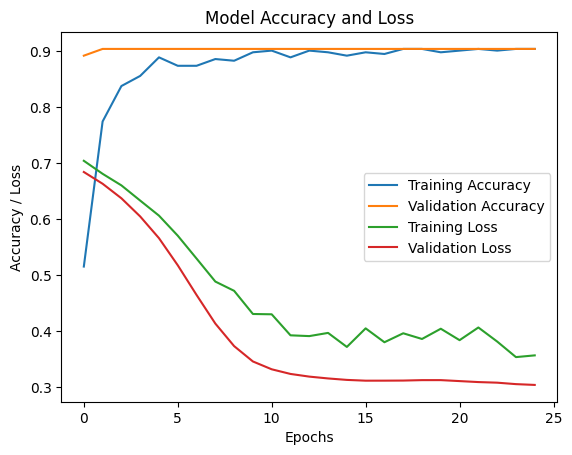

In [ ]:
# Step 10: Print Average Validation Loss and Accuracy
print(f"Average Validation Loss: {np.mean(val_losses)}, Average Validation Accuracy: {np.mean(val_accuracies)}")

# Step 11: Visualize Training History (Accuracy and Loss)
# Note: You may want to modify this part to visualize each fold's history if needed
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.show()

In [ ]:
from sklearn.utils import shuffle

# **Step 6: Rekomendasi Berdasarkan Kota dan Harga**
def recommend(city_name, price_category, waktu, top_n=3):
    """
    Memberikan rekomendasi tempat wisata berdasarkan kota dan kategori harga.

    Parameters:
        city_name: str - Nama kota yang dipilih.
        price_category: str - Kategori harga yang diinginkan ('Murah', 'Sedang', 'Mahal').
        top_n: int - Jumlah rekomendasi yang diinginkan.

    Returns:
        pd.DataFrame - DataFrame yang berisi nama tempat, kategori, deskripsi, rating, dan harga.
    """
    # Filter berdasarkan kota dan harga
    tm = 0
    if waktu == "morning":
      tm = 10
    elif waktu == "afternoon":
      tm = 15
    elif waktu == "evening":
      tm = 21
    city_filtered_df = places_df[places_df['City'].str.contains(city_name, case=False, na=False)]
    time_filtered_df = city_filtered_df[city_filtered_df['Opening_Time'] <= tm]
    time_filtered_df = time_filtered_df[time_filtered_df['Closing_Time'] >= tm]
    price_filtered_df = time_filtered_df[time_filtered_df['Price_Category'] == price_category]

    if price_filtered_df.empty:
        return f"No places found in city '{city_name}' with price category '{price_category}'."

    # Prepare input data
    category_input_data = price_filtered_df['Category_encoded'].values
    price_input_data = price_filtered_df['Price_Category_encoded'].values
    description_input_data = tfidf_matrix[price_filtered_df.index]

    # Shuffle the input data to avoid bias in the recommendation
    category_input_data, price_input_data, description_input_data = shuffle(category_input_data, price_input_data, description_input_data)

    # Predict similarity
    predictions = model.predict([category_input_data, price_input_data, description_input_data]).flatten()

    # Get top_n recommendations
    similar_indices = predictions.argsort()[-top_n:][::-1]
    recommended_places = price_filtered_df.iloc[similar_indices]

    # Output rekomendasi
    return recommended_places[['Place_Name', 'Category', 'Description', 'Rating', 'Price', 'Opening_Time', 'Closing_Time']]


In [ ]:
# example of use
recommendations = recommend("Jakarta", "Murah", "morning", 50)
print(len(recommendations))
recommendations

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
50


,Place_Name,Category,Description,Rating,Price,Opening_Time,Closing_Time
63,Pasar Petak Sembilan,Pusat Perbelanjaan,"Pecinan Glodok, tepatnya di Pasar Petak Sembil...",4.4,0,6,15
43,Taman Situ Lembang,Taman Hiburan,Taman Situ Lembang adalah sebuah taman kota ya...,4.5,0,6,18
46,Museum Joang 45,Budaya,Gedung Joang '45 atau Museum Joang 45 adalah s...,4.0,2000,9,15
20,Gereja Katedral,Tempat Ibadah,"Gereja Katedral Jakarta, atau bernama resmi Ge...",4.8,0,10,16
37,Museum Bahari Jakarta,Budaya,Museum Bahari adalah museum yang menyimpan kol...,4.4,2000,8,15
47,Jakarta Planetarium,Taman Hiburan,Planetarium dan Observatorium Jakarta adalah s...,4.1,12000,8,23
42,Pulau Semak Daun,Bahari,Pulau Semak Daun merupakan salah satu pulau ya...,4.0,40000,0,23
73,Plaza Indonesia,Pusat Perbelanjaan,Plaza Indonesia diresmikan pada awal tahun 199...,4.7,0,10,22
29,Setu Babakan,Budaya,Setu Babakan atau Danau Babakan terletak di Sr...,4.4,0,6,18
23,Pecinan Glodok,Pusat Perbelanjaan,Kawasan Glodok yang dikenal sebagai pusat perd...,4.3,0,7,19


In [ ]:
# Menyimpan model CBF yang sudah dilatih ke dalam file H5
model.save('cbf_model.h5')